# Propuesta "*Fourier coarse to fine CNN Model 256x256*"
## Alumno: Patrick Xavier Marquez Choque
## Curso: Proyecto Final de Carrera II
## Periodo: 2023-I

In [ ]:
######
#@title 1. Instalar Miniconda
######
%%capture
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-latest-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.anaconda.com/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

In [ ]:
######
#@title 2. Clonar Repositorio
######
%%capture
%%bash
rm -rf FcF-Inpainting/
git clone https://github.com/SHI-Labs/FcF-Inpainting
cd FcF-Inpainting/
pwd

In [ ]:
######
#@title 3. Crear el Entorno en Conda
######
%%capture
%%bash
conda init bash
conda env remove -n fcf
conda create --name fcf -y python=3.7

In [ ]:
######
#@title 4. Instalar Librerías y Dependencias
######
%%capture
%%bash
source activate fcf
conda env list
conda install pytorch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2 cudatoolkit=11.0 -c pytorch
cd /content/FcF-Inpainting/
pip3 install -r requirements.txt --quiet
pip3 uninstall opencv-python-headless -y --quiet
pip3 install opencv-python-headless --quiet

In [ ]:
######
#@title 5. Define Draw Mask Function
######

canvas_html = """
<style>
.button {
  background-color: #4CAF50;
  border: none;
  color: white;
  padding: 15px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  margin: 4px 2px;
  cursor: pointer;
}
</style>
<canvas1 width=%d height=%d>
</canvas1>
<canvas width=%d height=%d>
</canvas>

<button class="button">Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

var canvas1 = document.querySelector('canvas1')
var ctx1 = canvas.getContext('2d')


ctx.strokeStyle = 'red';

var img = new Image();
img.src = "data:image/%s;charset=utf-8;base64,%s";
console.log(img)
img.onload = function() {
  ctx1.drawImage(img, 0, 0);
};
img.crossOrigin = 'Anonymous';

ctx.clearRect(0, 0, canvas.width, canvas.height);

ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

import base64, os
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt
import numpy as np
from shutil import copyfile
import shutil

def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

In [ ]:
######
#@title 6. Descargar el Dataset de Places2 (256x256)
######
%%bash
cd /content/FcF-Inpainting/
wget https://shi-labs.com/projects/fcf-inpainting/places_256.pkl

--2023-07-10 06:33:59--  https://shi-labs.com/projects/fcf-inpainting/places_512.pkl
Resolving shi-labs.com (shi-labs.com)... 128.223.4.25
Connecting to shi-labs.com (shi-labs.com)|128.223.4.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 802650681 (765M) [application/octet-stream]
Saving to: ‘places_512.pkl’

     0K .......... .......... .......... .......... ..........  0%  361K 36m9s
    50K .......... .......... .......... .......... ..........  0%  724K 27m5s
   100K .......... .......... .......... .......... ..........  0% 64.7M 18m7s
   150K .......... .......... .......... .......... ..........  0%  110M 13m37s
   200K .......... .......... .......... .......... ..........  0%  727K 14m29s
   250K .......... .......... .......... .......... ..........  0% 59.1M 12m7s
   300K .......... .......... .......... .......... ..........  0% 82.0M 10m24s
   350K .......... .......... .......... .......... ..........  0%  155M 9m7s
   400K .......... ......

# Etapa de Pruebas

In [ ]:
######
#@title 7. Cargar las imágenes (256x256)
######
from google.colab import files
files = files.upload()
fnames = list(files.keys())

shutil.rmtree('./colab_data', ignore_errors=True)
! mkdir colab_data

for fn in fnames:
  copyfile(fn, f'./colab_data/{fn}')
  os.remove(fn)

Saving 1_256.jpg to 1_256.jpg


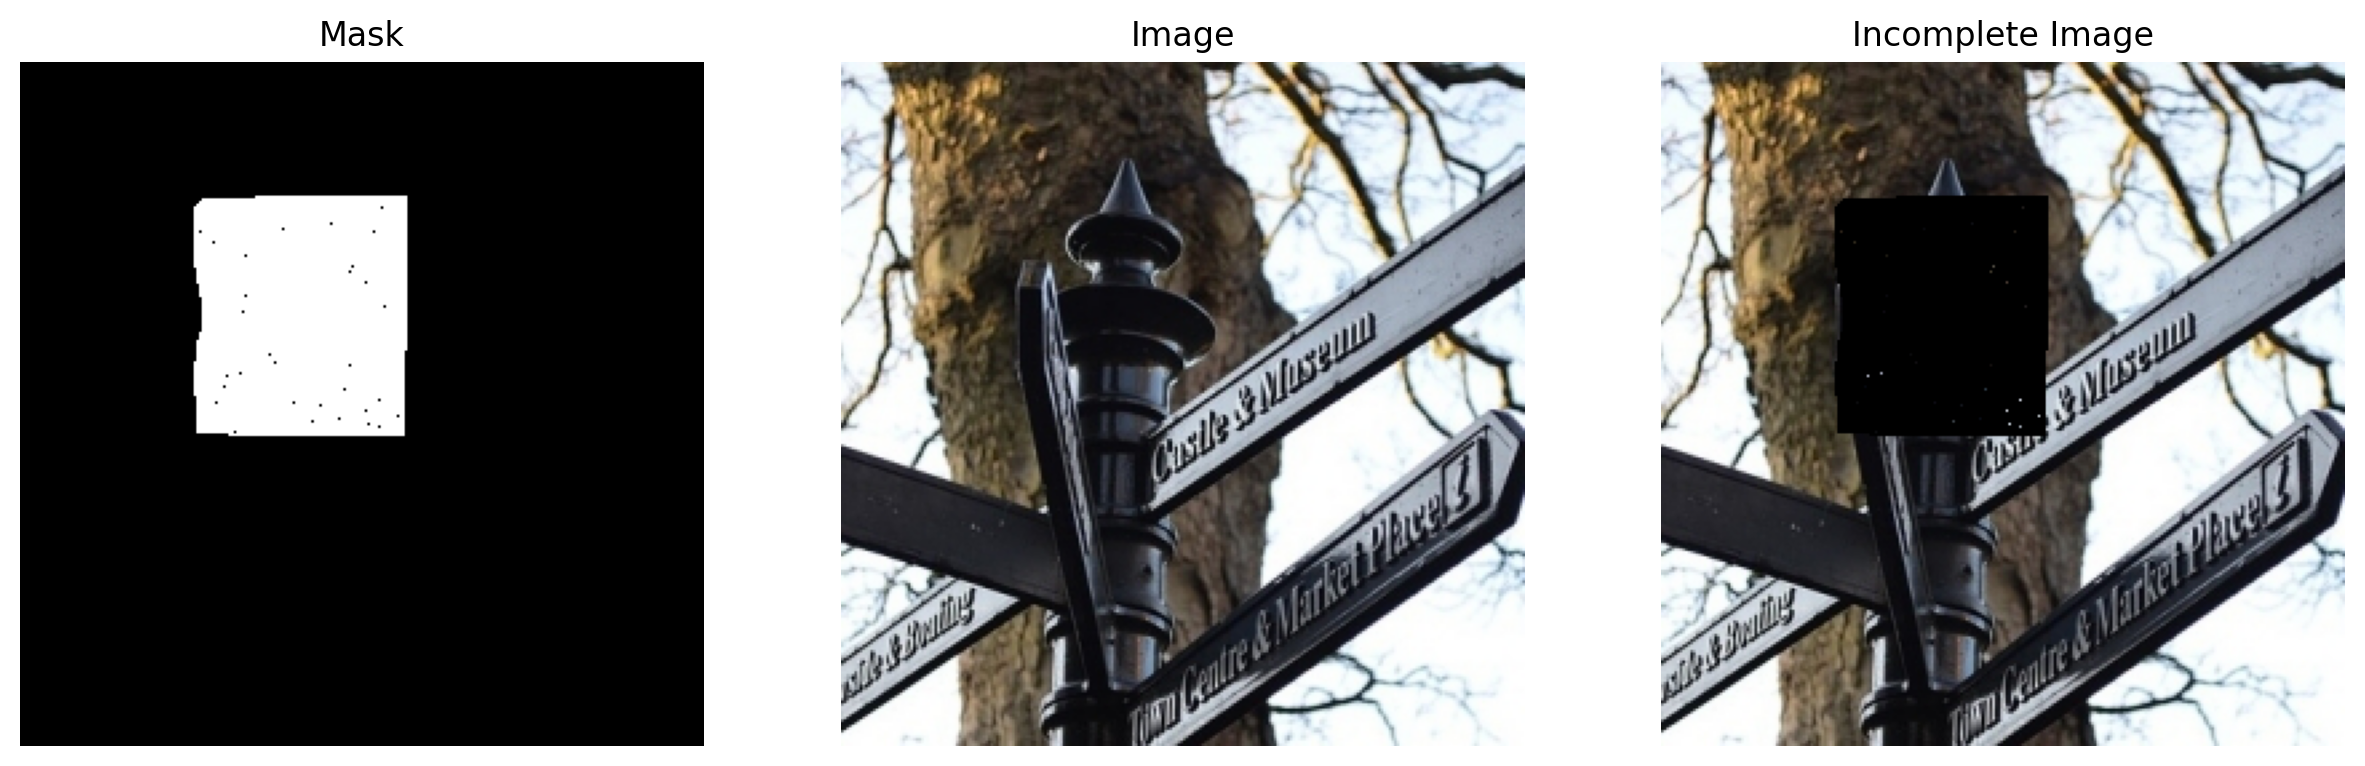

In [ ]:
#@title 8a. Dibujar la máscara
################
fname=f'./colab_data/{fnames[0]}'  ## Write filename here
################
image64 = base64.b64encode(open(fname, 'rb').read())
image64 = image64.decode('utf-8')

img = np.array(plt.imread(f'{fname}')[:,:,:3])

draw(image64, filename=f"./{fname.split('.')[1]}_mask.png", w=img.shape[1], h=img.shape[0], line_width=0.04*img.shape[1])

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['figure.dpi'] = 200
plt.subplot(131)
with_mask = np.array(plt.imread(f"./{fname.split('.')[1]}_mask.png")[:,:,:3])
mask = (with_mask[:,:,0]==1)*(with_mask[:,:,1]==0)*(with_mask[:,:,2]==0)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('Mask')
plt.imsave(f"./{fname.split('.')[1]}_mask.png",mask, cmap='gray')

plt.subplot(132)
img = np.array(plt.imread(f'{fname}')[:,:,:3])
plt.imshow(img)
plt.axis('off')
plt.title('Image')

plt.subplot(133)
img = np.array((1-mask.reshape(mask.shape[0], mask.shape[1], -1))*plt.imread(fname)[:,:,:3])
_=plt.imshow(img)
_=plt.axis('off')
_=plt.title('Incomplete Image')
plt.show()

In [ ]:
%%bash
################
export fname=1_256.png  ## Write filename here
################
cd /content/FcF-Inpainting/
source activate fcf
pip3 install -r requirements.txt --quiet
python colab_demo.py --img_path ../colab_data/$fname --output ../outputs --ckpt places_512.pkl
echo "Saved results to outputs/..."

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.1/282.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.9/207.9 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.1/38.1 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/envs/fcf/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
Traceback (most recent call last):
  File "colab_demo.py", line 102, in <module>
    img = Image.open(args.img_path)
  File "/usr/local/envs/fcf/lib/python3.7/site-packages/PIL/Image.py", line 3131, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '../colab_data/6458524847_2f4c361183_k.png'


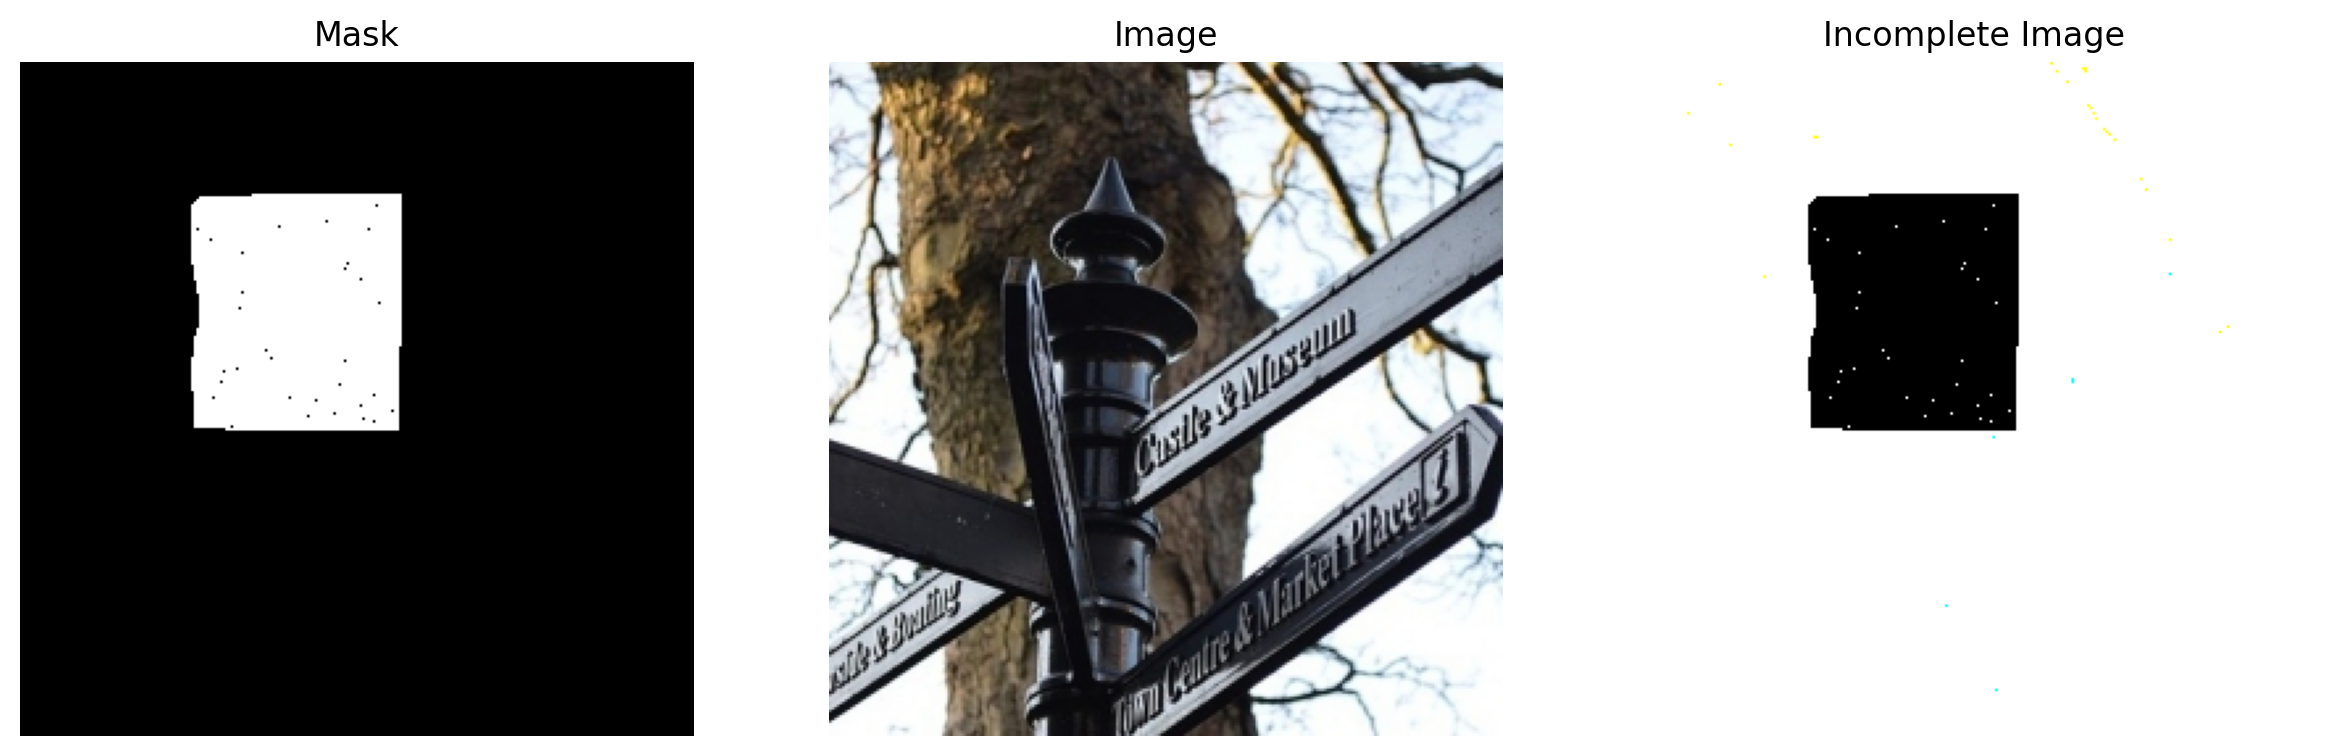

FileNotFoundError: ignored

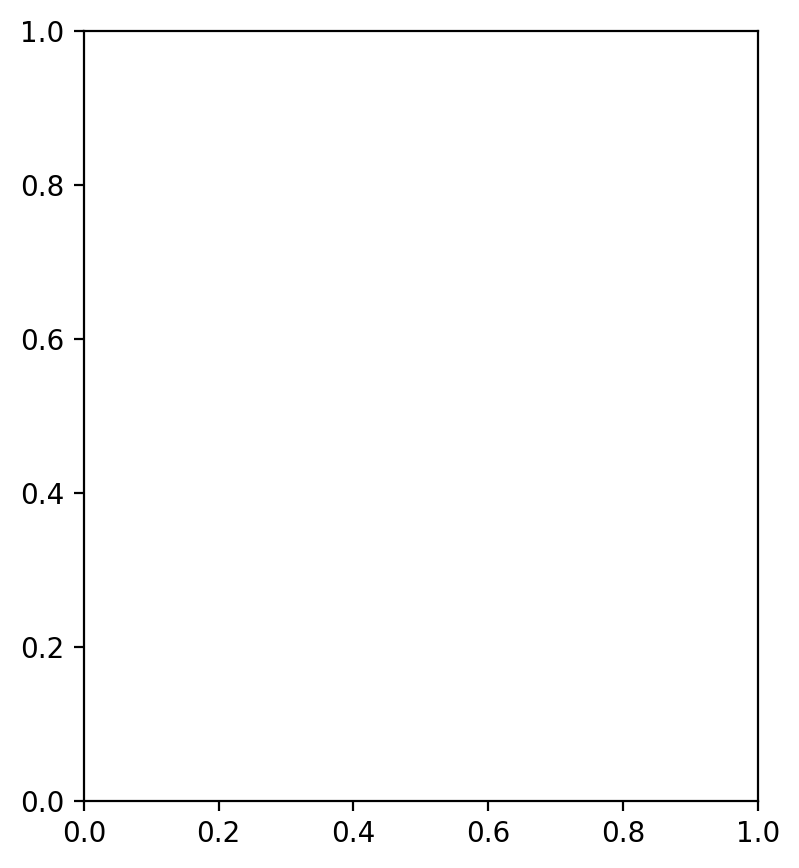

In [ ]:
################
fname=f'./colab_data/{fnames[0]}'
iname=fname.split('/')[-1]  ## Write filename here
################
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams['figure.dpi'] = 200
plt.subplot(141)
mask = np.array(plt.imread(f"./{fname.split('.')[1]}_mask.png")[:,:,:3])
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('Mask')

plt.subplot(142)
img = np.array(plt.imread(f'{fname}')[:,:,:3])
plt.imshow(img)
plt.axis('off')
plt.title('Image')

plt.subplot(143)
img = np.array((1-mask.reshape(mask.shape[0], mask.shape[1], -1))*plt.imread(fname)[:,:,:3])
_=plt.imshow(img)
_=plt.axis('off')
_=plt.title('Incomplete Image')
plt.show()

plt.subplot(144)
comp_img = np.array(plt.imread(f"outputs/{iname}")[:,:,:3])
plt.imshow(comp_img)
_=plt.axis('off')
_=plt.title('FcF-Inpainting Result')